The story of rabbits in Australia, and the resulting eradication efforts, provides a cautionary tale about viruses and immunity. This post will explore the growth of that population and the government's response to it.

Captive rabbits were first introduced into Australia in 1788 by the first European settlement - the penal colony at Botany Bay. The early settlers brought only five rabbits with them to Australia. The rabbits were kept for food and bred but never released into the wild. More rabbits subsequently arrived as settlements dotted the Australian landscape. They spread around Tasmania (then known as Van Diemen’s Land) but were mostly controlled on the mainland and didn’t spread into the wild.
The settlers were able to keep the rabbit population in captivity and under control for over half a century, until one thing happened - they got bored. They wanted to hunt rabbits like they did in England and so, in 1859, they released 24 rabbits into the wild. From there the population grew, like, well, rabbits.


To simulate the population, we'll need an equation for population growth. The population will change by the growth factor, which is the difference in the birth and death rates, times the population size. Mathematically, this would be written as:

$$\dfrac{\mathrm{d}P}{\mathrm{d}t} = P*(b-d)$$

where

* $\dfrac{\mathrm{d}P}{\mathrm{d}t}$ - change in population
* $P$ - population
* $b$ - birth rate
* $d$ - death rate

The birth and death rates are usually combined into a single factor, the growth rate $r$, where $r=b-d$. We can plug this in and  integrate the differential equation to give us the standard equation for exponential population growth:

$$P(t) = Pe^{rt}$$

This equation works well enough in the beginning, but it misses an important component - carrying capacity. Carrying capacity refers to the maximum population that the land can contain. There are limited amounts of food and shelter for the rabbits to survive, so at some point they must reach capacity. We have to add a "carrying capacity factor" to the differential equation.

However, this doesn't allow us enough precision. For example, rabbits don't reach sexual maturity until 17 weeks - how do we factor that in? We'll have to distinguish the sexually mature population from the rest.

$$\dfrac{\mathrm{d}P}{\mathrm{d}t} =P_m * (b-d) * (1 - P_{tot}/K)$$

where

* $\dfrac{\mathrm{d}P}{\mathrm{d}t}$ - change in population
* $P_m$ - sexually mature population
* $b$ - birth rate
* $d$ - death rate
* $P_{tot}$ - total population
* $K$ - carrying capacity

Now we have to start pluggin in the numbers. Rabbits have a gestation period of about four weeks, and each new litter of rabbits contains four baby bunnies. And there's no relaxing, right after giving birth they can start the process again. So if it takes two rabbits four weeks to make four baby rabbits, that’s a growth rate of about .5 rabbits per week for each rabbit. Rabbits in the wild live an average of roughly a year, so we'll give them a death rate of .02.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.core.debugger import set_trace

In [2]:
# Rabbit facts
time_to_sexual_maturity = 17 #weeks
birth_rate = .5 # the growth rate is 4 babys /2 parents /4 weeks = .5
death_rate =.02 # lifespan is about a year, so we'll say 50 weeks
# birth_rate contains those with immunity, death rate doesn't

In [12]:
# Build a function to spread the disease
def spread_myxo(infected, immune, total, infection_rate): #infected is the number of infected rabbits, total is the total population
    """This function return the number of newly infected rabbits"""
    susceptible = total - immune - infected
    percent_infected = infected / total
    new_infections = round(susceptible * (2/(1+math.exp(-infection_rate*percent_infected)) - 1))
    return new_infections

In [66]:
def project_population(num_weeks, week_myxo_released=float("inf"), rabbit_population=None, infected=None, \
       immune=None, carrying_capacity=600000000, num_myxo_released = 5000, chance_of_mutation_immunity=0, \
       myxo_inhereted_immunity = 0, infection_rate=.5, inf_capacity_factor=0, resist_capacity_factor=0, \
                       extermination_week=float("inf"), extermination_number=0):
    """This function shows the population change over time. It functions with and without the viral or immunity information"""
   
    # If no initial values are given, initiate them as empty
    if rabbit_population == None:
        rabbit_population = np.zeros(num_weeks)
        rabbit_population[0] = 24
    if infected == None:
        infected = np.zeros(num_weeks)
    if immune == None:
        immune = np.zeros(num_weeks)
    # Initialize other values to 0
    new_infections = 0
    newly_infected = np.zeros(num_weeks)
    infected_1_week_ago_remaining = np.zeros(num_weeks)
    infected_2_week_ago_remaining = np.zeros(num_weeks)
    deaths_from_infection = 0

    # The death rate will affect many things, so we'll need to find the fraction that remain
    assert (0 <= death_rate <= 1), "Death rate should be between 0 and 1"
    percent_remaining = 1 - death_rate
    
    # Iterate over each week, starting at 1
    for x in range(1, num_weeks):
        
        # Check that the rabbit population is still viable
        if rabbit_population[x-1] < 2:
            print("Rabbits have been removed")
            #set_trace()
            break
            
        # Determine the number of sexually mature rabbits in the given week
        if x < 17:
            sexually_mature_population = 24
        else:
            # The sexually mature population is at most the population of 17 weeks ago, but could be less
            # This gives us reasonable value for growing, shrinking, and changing population
            sexually_mature_population = rabbit_population[x-1] * min(rabbit_population[x-17:x]) / max(rabbit_population[x-17:x])
            
        new_births = round(sexually_mature_population * birth_rate)
        
        percent_immune = immune[x-1]/rabbit_population[x-1]
        
        # if either parent has immunity, the newborn might inherit immunity
        inhereted_immunity = round(new_births * percent_immune * myxo_inhereted_immunity)
        
        # Rabbits without immune parents may have it through mutation, much less likely though
        mutation_immunity = round(new_births * (1 - percent_immune) * chance_of_mutation_immunity)
        
        # Then factor in normal death rate
        # We'll also need  to factor in deaths into the infect and immune populations
        draft_population = round(rabbit_population[x-1] * percent_remaining + new_births)
        draft_infected = round(infected[x-1] * percent_remaining)
        draft_immune = round(immune[x-1] * percent_remaining + inhereted_immunity + mutation_immunity)
        
        # Now let's see how the infection spreads
        # Check if the myxo virus has been released
        if x == week_myxo_released:
            newly_infected[x] = num_myxo_released
        elif x > week_myxo_released:
            
            # Advance each stage of myxo by one week
            deaths_from_infection = round(infected_2_week_ago_remaining[x-1] * percent_remaining)
            draft_infected_2_week_ago_remaining = round(infected_1_week_ago_remaining[x-1] * percent_remaining)
            draft_infected_1_week_ago_remaining = round(newly_infected[x-1] * percent_remaining)
            infected_remaining = round(infected[x-1] * percent_remaining)
            # Check that there aren't more infected than total (can happen due to rounding)
            if infected_remaining > draft_population:
                infected_remaining = draft_population
            
            # We'll assume those about to die can still spread infection
            new_infections = round(spread_myxo(infected_remaining, draft_immune, draft_population, \
                                               infection_rate))           
        
        # Now remove those dying from the population
        if draft_population > deaths_from_infection:
            second_draft_population = draft_population - deaths_from_infection
        else:
            second_draft_population = 1 # To avoid div by zero
            
        # Now we see how many die due to being near carrying capacity    
        overcapacity_deaths = round(second_draft_population * (second_draft_population/carrying_capacity) * \
                                    (birth_rate-death_rate))
        
        # Calculate the percentage of the population remaining
        # e.g. if 20% of the population died, the overcapacity_deaths_factor is .8
        overcapacity_deaths_remaining = 1 - overcapacity_deaths / second_draft_population

        # We'll subtract the overcapacity deaths from each field
        # In the population case, this is equal to rabbit_population[x] = draft_rabbit_population - overcapacity_deaths
        rabbit_population[x] = round(second_draft_population * overcapacity_deaths_remaining)
        if x > week_myxo_released:
            infected_2_week_ago_remaining[x] = round(draft_infected_2_week_ago_remaining * overcapacity_deaths_remaining)
            infected_1_week_ago_remaining[x] = round(draft_infected_1_week_ago_remaining * overcapacity_deaths_remaining)
            newly_infected[x] = round(new_infections * overcapacity_deaths_remaining)
        immune[x] = round(draft_immune * overcapacity_deaths_remaining)
        
        infected[x] = newly_infected[x] + infected_1_week_ago_remaining[x] + infected_2_week_ago_remaining[x]
        
        # Check for human-cause extermination
        if x == extermination_week:
            rabbit_population[x] -= extermination_number
        
        # Check for errors or incorrect values
        
        if new_infections < 0:
            set_trace()
        
        if rabbit_population[x] <= 0:
            #set_trace()
            print("Rabbit population less than or equal to 0")
            rabbit_population[x] = 1 # To avoid div by zero
        
        if immune[x] > rabbit_population[x]:
            print("too many immune")
            set_trace()
            immune[x] = rabbit_population[x]
            infected_1_week_ago_remaining = 0
            newly_infected[x]=0
        if immune[x] < 0:
            print("immune less than zero")
            set_trace()
            immune[x] = 0
        
        if newly_infected[x] < 0:
            set_trace()
            newly_infected[x] = 0

        if newly_infected[x] > rabbit_population[x] - immune[x]:
            set_trace()
            newly_infected[x] = rabbit_population[x] - immune[x]
               
    return rabbit_population, infected, immune

In [64]:
def plot_rabbits(rabbit_population, infected = None, immune = None, title="Rabbit growth in Australia"):
    """This function plots the rabbit population. It will also plot the infected and immune populations"""
    x = np.arange(len(rabbit_population))
    fig, ax = plt.subplots()
    ax.fill_between(x, 0, rabbit_population, color='g')
    #ax.fill_between(x, 0, infected, color='r')
    if immune is not None:
        ax.fill_between(x, 0, immune, color='b')
    if infected is not None:
        ax.fill_between(x, 0, infected, color='r')
    ax.set_title(title)
    ax.set_xlabel("Weeks after first rabbits introduced")
    ax.set_ylabel("Number of rabbits")
    if infected is not None and immune is not None:
        ax.legend(("Total rabbits", "Immune rabbits", "Infected rabbits"), loc='upper left')
    elif infected is not None:
        ax.legend(("Total rabbits", "Infected rabbits"), loc='upper left')
    else:
        ax.legend(("Total rabbits",), loc='upper left') # Trailing comma request to print entire label.
    plt.show()

In [65]:
rabbit_population, infected, immune = project_population(52)

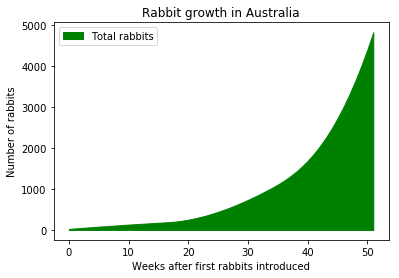

In [58]:
plot_rabbits(rabbit_population)

5000 rabbits. That’s a lot, but it’s manageable. But herein lies the problem with exponential growth. You many have a manageable number after a year, but after a second year you have:

In [50]:
rabbit_population, infected, immune = project_population(104)

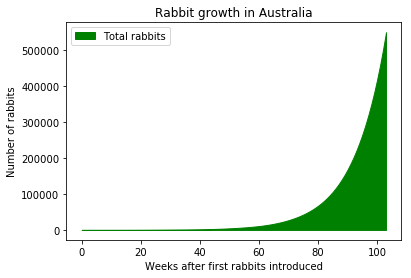

In [51]:
plot_rabbits(rabbit_population)

Half a million rabbits! It’s a classic example of unintended consequences. And given the expanse of the Australian landscape, the limit to the number of rabbits is huge. Based on population estimates, the maximum population for rabbits in a huge country like Australia is in the hundreds of millions (remember, the human population is only 24 million). Based on the exponential growth of rabbits, they would near this number in only four years. Due to the additional time it would take to spread proportionally throughout the country, it probably took a bit longer than that. Either way, it was the fastest spread ever recorded of any mammal anywhere in the world.

In [60]:
rabbit_population, infected, immune = project_population(520)

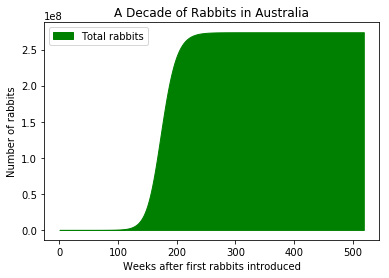

In [62]:
plot_rabbits(rabbit_population, title="A Decade of Rabbits in Australia")

Obviously, hundreds of millions additional animals competing with native wildlife for food and water has a devastating impact. The vast amount of plant life they consume not only decimates the native plant life, but that in turn causes erosion, which leads to nutrient-poor soil, thus increasing the damage. It wasn’t long before the Australian government determined that rabbits were causing significant economic damage. In 1887, the government of New South Wales started soliciting methods for removing them.

The most obvious method - hunt them, isn’t actually very effective. There were efforts to shoot, trap, and poison them. The efforts were expensive, but ultimately had little impact against the robust rabbit population. To get an idea of the futility, imagine launching a tremendous rabbit hunting, trapping, and poisoning campaign that is so incredible effective that it causes the death of 50 million rabbits in a single week. But the moment that expensive campaign is stopped, which would come eventually, the population just regrows. Here’s a simulation of 50 million rabbits being killed in week 250. As you can see, within a year the population has recovered.

In [78]:
rabbit_population, infected, immune = project_population(302, extermination_week=250, extermination_number=50000000)

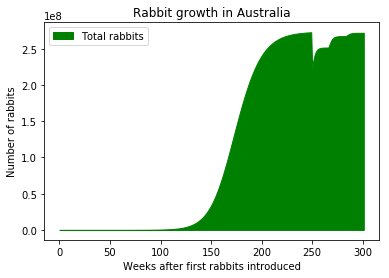

In [79]:
plot_rabbits(rabbit_population)

But in the 1950’s, after decades and decades of ineffective techniques, the Australian Government tried something different - biological warfare. Viruses are incredibly effective at population control because after the target is infected, it finds new victims automatically, and the virus spreads by itself. The trouble is, how can you find a virus that’s safe to release in the wild but will not wreak havoc on the ecosystem?

The myxoma virus seemed like a perfect candidate. It causes myxomatosis, a deadly disease specifically targeted towards rabbits. Although myxoma infects several mammals, from rabbits and mice to humans, it can only replicate in the cells of rabbits. Without the ability to replicate in the cells, as in the case of humans, it never causes myxomatosis and is harmless. On top of that, myxoma virus spreads easily and kills rabbits within two weeks (depending on the species).

After some initial trials, the technique was approved and released into the rabbit population. The rabbit population quickly cut in half, then in half again. The disease continued to spread and kill more and more rabbits. Based on the deadly efficacy of myxomatosis, the rabbit population should have been completely wiped out.

Assuming each rabbits spreads the disease to two others, this is the simulation for how it should have gone after releasing myxoma in week 250.

In [127]:
rabbit_population, infected, immune = project_population(350, week_myxo_released=250, infection_rate=2)

Rabbits have been removed


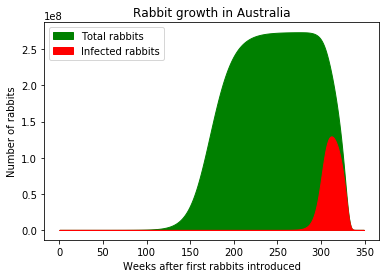

In [128]:
plot_rabbits(rabbit_population, infected)

But that's not what happened. The problem is, in any large population, there’s likely to be some members that, through chance genetic mutation, have a natural resistance. This is true for nearly all diseases. Some people were naturally immune to the Black Death that killed half of all Europeans in the 14th century. Even HIV has a rival in people born with a mutation known as Delta32.

Myxoma was terribly effective on rabbits, but even if we assume efficacy against 99.99% of the population, there are still some with immunity. And once all the susceptible rabbits die, those with immunity breed and pass on their immunity to their progeny. Here's a simulation with the same virality as before, but giving 0.01% of the population immunity, and assuming that immunity passes on to the next generation 99% of the time.

In [134]:
rabbit_population, infected, immune = project_population(1800, week_myxo_released=400, infection_rate=2,  chance_of_mutation_immunity=0.0001, \
       myxo_inhereted_immunity = .99)

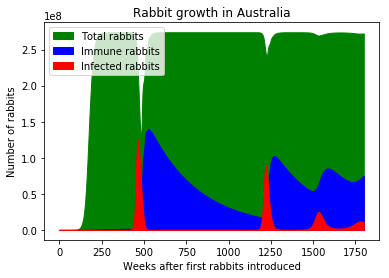

In [135]:
plot_rabbits(rabbit_population, infected, immune)

Although the virus has a large impact initially, every time the virus starts to take hold the immune rabbits, with no more competition from all those who died, spread across the land and themselves number in over 100 million. And so, the myoma virus experiment ended, leaving Australia with a large population of mutant, disease-resistant rabbits.